# <b>CS156 (Introduction to AI), Fall 2022</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: Rohan Athalye
### Student ID: 014099982
### Email address: rohan.athalye@sjsu.edu

##  <u>References and sources</u>

- CNN.Dog_vs_cat_images.ipynb from Canvas under Files/Example Jupyter Notebooks
- CNN.MNIST.ipynb from Canvas under Files/Example Jupyter Notebooks
- https://stackoverflow.com/questions/64687375/get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory
- https://www.kaggle.com/code/grfiv4/plot-a-confusion-matrix/notebook

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.get_logger().setLevel('ERROR')
import os
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

In [ ]:
np.random.seed(42)

#### Code the solution

#### Generate training, validation, and test datasets

In [ ]:
image_size = (180, 180)
batch_size = 32
train_path = r"C:\Users\ronro\Downloads\flowers\training"
test_path = r"C:\Users\ronro\Downloads\flowers\test"

# Generates the training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

# Generates the validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

# Generates the test dataset.
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="categorical",
    seed=42,
    image_size=image_size,
    batch_size=1)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


#### Augment the data

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#### Define model architecture

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block.
    x = data_augmentation(inputs)

    # Entry block.
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual.

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual.
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Adds back residual.
        previous_block_activation = x  # Sets aside next residual.

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=5)

#### Train the model on training/validation data

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 342s 4s/step - loss: 1.2695 - accuracy: 0.5121 - val_loss: 1.6892 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 368s 4s/step - loss: 0.9948 - accuracy: 0.6228 - val_loss: 2.0622 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 375s 4s/step - loss: 0.8733 - accuracy: 0.6778 - val_loss: 2.9094 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 396s 5s/step - loss: 0.8229 - accuracy: 0.6937 - val_loss: 3.3106 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 396s 5s/step - loss: 0.7346 - accuracy: 0.7273 - val_loss: 3.6528 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 397s 5s/step - loss: 0.7393 - accuracy: 0.7360 - val_loss: 2.2860 - val_accuracy: 0.2865
Epoch 7/20
87/87 [==============================] - 396s 5s/step - loss: 0.6418 - accuracy: 0.7617 - val_loss: 1.3261 - val_accuracy: 0.5803
Epoch 8/20
87

#### Evaluate the model using the test data

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.154082179069519
Test accuracy: 0.7224158048629761


#### Compute a confusion matrix for predictions on the set of test images

In [ ]:
predicted_labels = np.array([])
true_labels =  np.array([])

# Iterates over test images and obtains predicted vs. true labels for each test image.
# Each predicted label is added to a list, and each true label is added to another list.
for x, y in test_ds:
    predicted_labels = np.concatenate([predicted_labels, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, np.argmax(y.numpy(), axis=-1)])
    
# Computes the confusion matrix.
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy();

#### Plot a confusion matrix

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    
    import itertools
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy = {:0.4f}; Misclassification = {:0.4f}'.format(accuracy, misclass))
    plt.show()

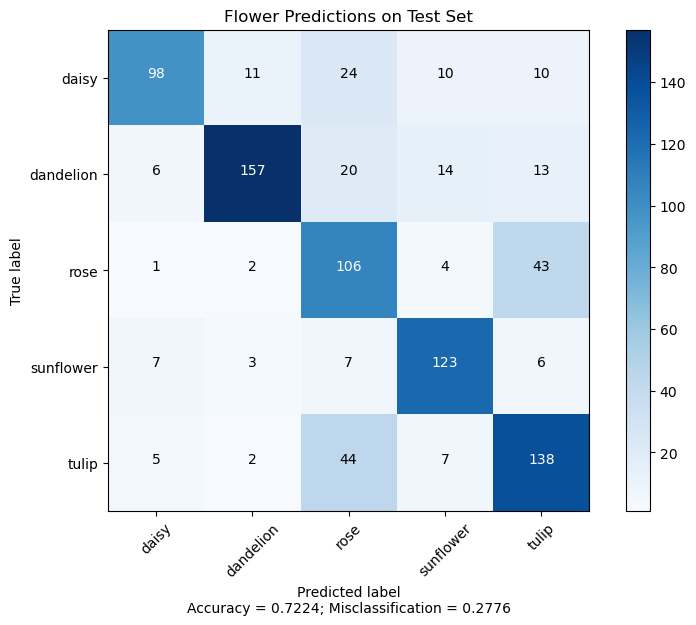

In [ ]:
label_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
plot_confusion_matrix(cm, label_names, "Flower Predictions on Test Set", normalize=False)

#### Output 3 misclassified images along with the true and predicted labels for those images

1/1 [==============================] - 0s 101ms/step
Daisy: 0.0011568279660423286
Dandelion: 0.024909121566452086
Rose: 4.998661928823367e-07
Sunflower: 99.97387528419495
Tulip: 5.984121003166365e-05


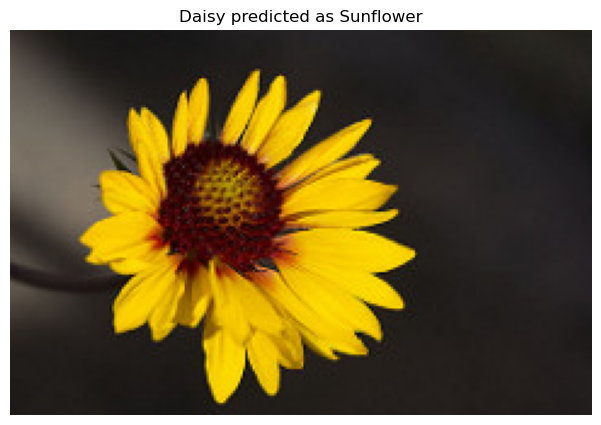

In [ ]:
path = r"C:\Users\ronro\Downloads\flowers\test\daisy\34518374242_310e7abd54_n.jpg"
img = io.imread(path)
plt.figure(figsize=(8,5))
plt.title("Daisy predicted as Sunflower")
plt.axis("off")
plt.imshow(img)

img = keras.preprocessing.image.load_img(path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Creates batch axis.

predictions = model.predict(img_array)
score = predictions[0]

print("Daisy:", score[0] * 100)
print("Dandelion:", score[1] * 100)
print("Rose:", score[2] * 100)
print("Sunflower:", score[3] * 100)
print("Tulip:", score[4] * 100)

1/1 [==============================] - 0s 102ms/step
Daisy: 0.015653403534088284
Dandelion: 3.4712678598225466e-05
Rose: 0.012163382052676752
Sunflower: 0.00014554622111973003
Tulip: 99.972003698349


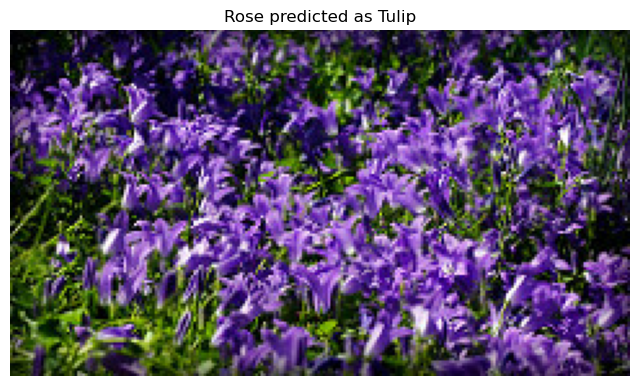

In [ ]:
path = r"C:\Users\ronro\Downloads\flowers\test\rose\18492322571_3b99e55560_n.jpg"
img = io.imread(path)
plt.figure(figsize=(8,5))
plt.title("Rose predicted as Tulip")
plt.axis("off")
plt.imshow(img)

img = keras.preprocessing.image.load_img(path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Creates batch axis.

predictions = model.predict(img_array)
score = predictions[0]

print("Daisy:", score[0] * 100)
print("Dandelion:", score[1] * 100)
print("Rose:", score[2] * 100)
print("Sunflower:", score[3] * 100)
print("Tulip:", score[4] * 100)

1/1 [==============================] - 0s 120ms/step
Daisy: 0.002627368667162955
Dandelion: 0.006451209628721699
Rose: 0.016287129255943
Sunflower: 99.91182684898376
Tulip: 0.0628077716100961


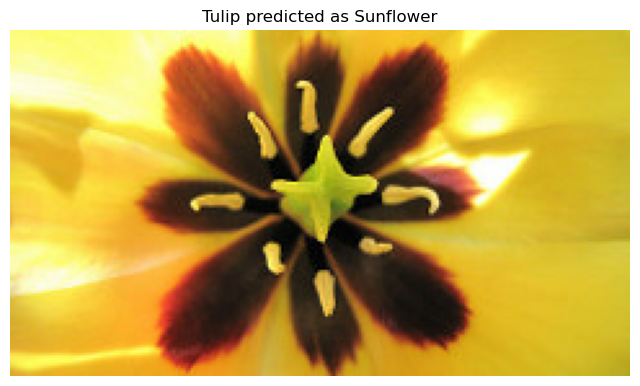

In [ ]:
path = r"C:\Users\ronro\Downloads\flowers\test\tulip\20489160931_3c445b6b02_n.jpg"
img = io.imread(path)
plt.figure(figsize=(8,5))
plt.title("Tulip predicted as Sunflower")
plt.axis("off")
plt.imshow(img)

img = keras.preprocessing.image.load_img(path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Creates batch axis.

predictions = model.predict(img_array)
score = predictions[0]

print("Daisy:", score[0] * 100)
print("Dandelion:", score[1] * 100)
print("Rose:", score[2] * 100)
print("Sunflower:", score[3] * 100)
print("Tulip:", score[4] * 100)